# Importing libraries 

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Loading data 

In [87]:
df_customers=pd.read_csv('Customers.csv')
df_products=pd.read_csv('Products.csv')
df_transactions=pd.read_csv('Transactions.csv')

# Merging the data

In [88]:
transactions_with_products = df_transactions.merge(df_products, on='ProductID', how='left')
full_data = transactions_with_products.merge(df_customers, on='CustomerID', how='left')

In [89]:
customer_profiles = full_data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    avg_transaction_value=('TotalValue', 'mean'),
    total_transactions=('TransactionID', 'count'),
    total_quantity=('Quantity', 'sum'),
    categories_purchased=('Category', lambda x: list(x.unique())),
    regions=('Region', 'first')
).reset_index()

customer_profiles = customer_profiles.merge(
    df_customers[['CustomerID', 'CustomerName', 'SignupDate']],
    on='CustomerID',
    how='left'
)



# Encoding categories and regions

In [90]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
categories_encoded = pd.DataFrame(
    mlb.fit_transform(customer_profiles['categories_purchased']),
    columns=mlb.classes_,
    index=customer_profiles.index
)

regions_encoded = pd.get_dummies(customer_profiles['regions'], prefix='region')

# Scaling

In [91]:
scaler = StandardScaler()
numerical_features = ['total_spent', 'avg_transaction_value', 'total_transactions', 'total_quantity']
numerical_scaled = pd.DataFrame(
    scaler.fit_transform(customer_profiles[numerical_features]),
    columns=numerical_features,
    index=customer_profiles.index
)


In [92]:
profile_features = pd.concat([numerical_scaled, categories_encoded, regions_encoded], axis=1)

In [93]:
pca = PCA(n_components=10)  
profile_features_pca = pd.DataFrame(
    pca.fit_transform(profile_features),
    index=profile_features.index
)

# Cosine similarity

In [94]:
similarity_matrix = cosine_similarity(profile_features_pca)

In [95]:
customer_ids = customer_profiles['CustomerID'].values
top_20_indices = [i for i, cust_id in enumerate(customer_ids) if cust_id.startswith('C00')][:20]

In [96]:
lookalike_results = {}
for idx in top_20_indices:
    similar_indices = similarity_matrix[idx].argsort()[-4:-1][::-1]  # Exclude self and get top 3
    similar_customers = [(customer_ids[i], round(similarity_matrix[idx, i], 4)) for i in similar_indices]
    lookalike_results[customer_ids[idx]] = similar_customers

In [97]:
lookalike_data = []
for cust_id, lookalikes in lookalike_results.items():
    lookalike_data.append({
        "cust_id": cust_id,
        "lookalikes": str(lookalikes)  # Store as string for CSV
    })


# Saving to csv file

In [100]:
lookalike_df = pd.DataFrame(lookalike_data)
lookalike_df.to_csv('SKSai_Tarun_Lookalike.csv', index=False)

# Cosine Similarity Distribution

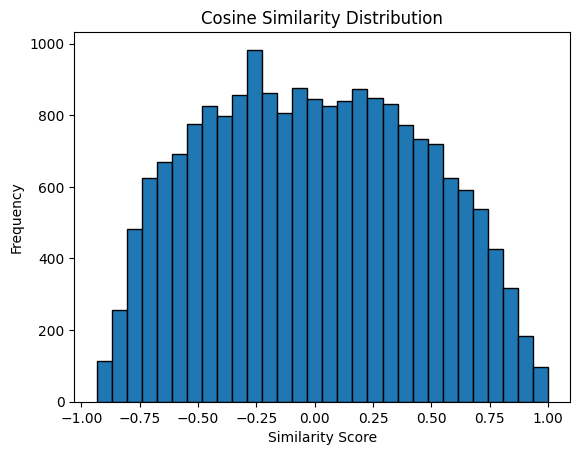

In [99]:
import matplotlib.pyplot as plt
similarities = similarity_matrix[np.triu_indices(len(similarity_matrix), k=1)]  # Upper triangular values only
plt.hist(similarities, bins=30, edgecolor='black')
plt.title("Cosine Similarity Distribution")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()